In [1]:
from json import loads

import matplotlib.pyplot as plt
import numpy as np
from tabulate import tabulate

In [2]:
def matches(row, q):
    if isinstance(q, dict):
        return isinstance(row, dict) and all(key in row and matches(row[key], q[key]) for key in q.keys())
    elif isinstance(q, float):
        return isinstance(row, float) and abs(q - row) < 1e-6
    else:
        return row == q

def query(db="db", q={}):
    res = []
    with open(f"{db}.txt", "r") as fd:
        for i, line in enumerate(fd):
            data = loads(line)
            if matches(data, q):
                res.append({**data, "_id": i})
    return res

def query_first(q):
    with open("db.txt", "r") as fd:
        for i, line in enumerate(fd):
            data = loads(line)
            if matches(data, q):
                return {**data, "_id": i}
    return None

In [3]:
ODES = ["L-ODE1", "L-ODE2", "L-ODE3", "L-ODE4", "L-ODE5", "L-ODEn1", "L-ODEn2", "L-ODEn3", "NL-ODE1", "NL-ODE2", "NL-ODE3", "NL-ODE4", "NL-ODEn1", "NL-ODEn2", "SODE1", "SODE2", "SODE3", "PDE1", "PDE2", "PDE3", "PDE4", "PDE5", "PDE6", "PDE7", "PDE8", "PDE9", "PDE10"]

In [34]:
def make_plot(experiments, param_name, params, func, name, exclude_sode3=False, odes=ODES, row_labels=None):
    odes = [ode for ode in odes if ode != "SODE3"] if exclude_sode3 else ODES
    data = np.log10(np.array([
        [
            (lambda x,y:1e10 if len(x) == 0 else func(x, y))(
                [
                    x["losses"][-1]
                    for x in experiments
                    if x["kwargs"]["ode"] == ode and x["kwargs"][param_name] == param],
                [
                    x["errors"][-1]
                    for x in experiments
                    if x["kwargs"]["ode"] == ode and x["kwargs"][param_name] == param]
            )
            for ode in odes
        ] for param in params]))
    plt.figure(figsize=(30,10))
    im = plt.imshow(data, vmin=-7, vmax=2, cmap="seismic")

    plt.xticks(np.arange(len(odes)), odes)
    if row_labels is None:
        row_labels = params
    plt.yticks(np.arange(len(params)), row_labels)

    for i in range(len(params)):
        for j in range(len(odes)):
            plt.text(j, i, f"{data[i, j]:.1f}", ha="center", va="center", color="w")

    plt.title(name)
    plt.show()

# def make_table(experiments, param_name, params):
#     res = {
#         ode: {
#             str(param): [x for x in experiments if x["kwargs"]["ode"] == ode and x["kwargs"][param_name] == param]
#             for param in params
#         } for ode in ODES
#     }
#     def format(xs):
#         return ", ".join(f"{x:.2e}" for x in xs)
#     data = [
#         [ode] + [
#             format([
#                 np.log10(np.mean([x["losses"][-1] for x in res[ode][str(param)]])),
#                 np.log10(np.mean([x["errors"][-1] for x in res[ode][str(param)]]))
#             ])
#             for param in params
#         ]
#         for ode in ODES
#     ]

#     print(tabulate(data, headers=["ode"]+params))#, tablefmt="fancy_grid"))
    
def make_plots(db, params, param_name, row_labels=None, odes=ODES):
    experiments = [x["payload"] for x in query(db)]
    make_plot(experiments, param_name, params, lambda l,e:np.mean(l), f"{param_name} log10(loss)", odes, row_labels=row_labels)
    make_plot(experiments, param_name, params, lambda l,e:np.mean(e), f"{param_name} log10(error)", exclude_sode3=True, odes=odes, row_labels=row_labels)
#     make_table(experiments, param_name, params)

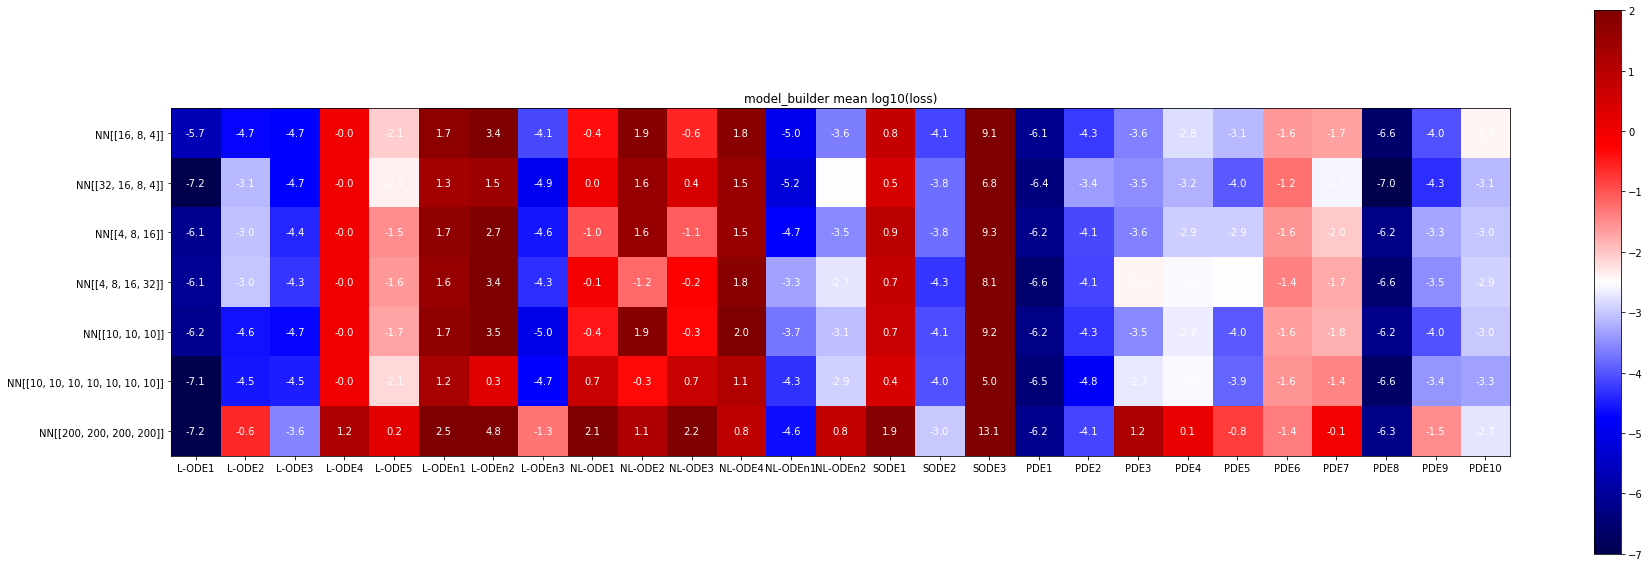

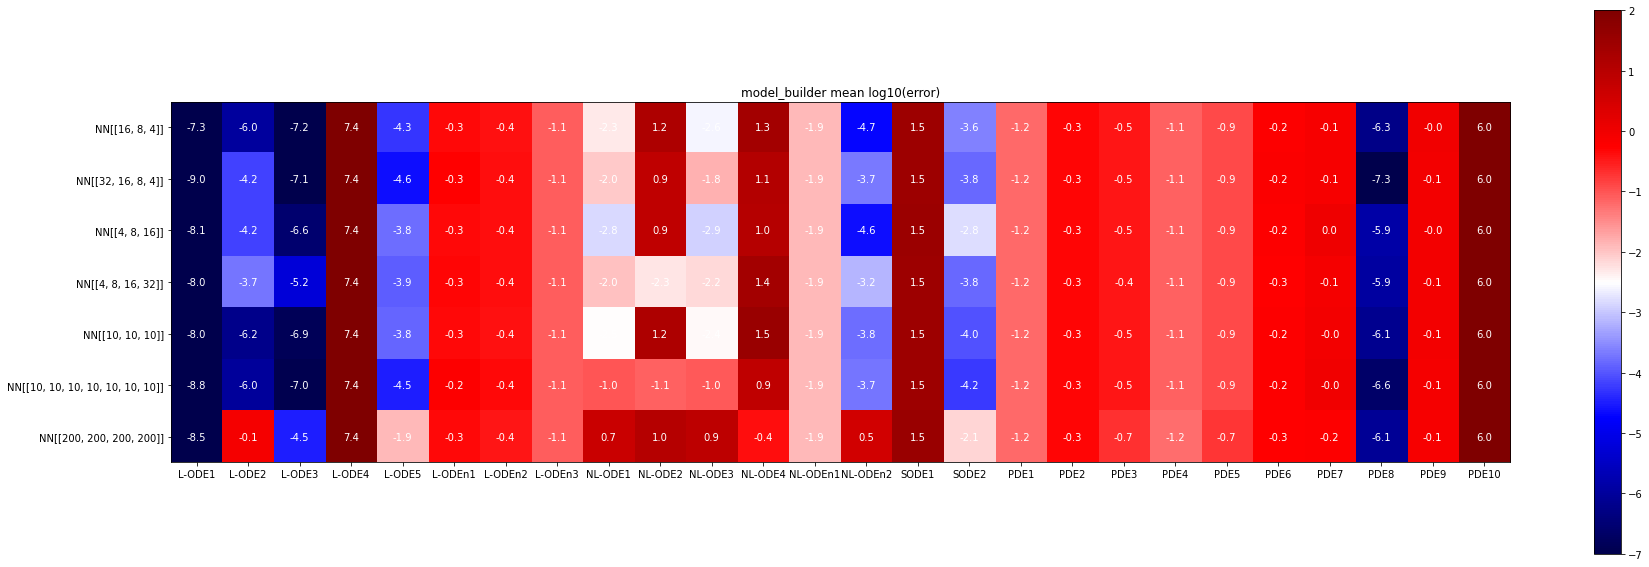

ode       NN[[16, 8, 4]]        NN[[32, 16, 8, 4]]    NN[[4, 8, 16]]        NN[[4, 8, 16, 32]]    NN[[10, 10, 10]]      NN[[10, 10, 10, 10, 10, 10, 10]]    NN[[200, 200, 200, 200]]
--------  --------------------  --------------------  --------------------  --------------------  --------------------  ----------------------------------  --------------------------
L-ODE1    -5.66e+00, -7.28e+00  -7.19e+00, -9.02e+00  -6.14e+00, -8.08e+00  -6.11e+00, -7.97e+00  -6.18e+00, -7.96e+00  -7.09e+00, -8.76e+00                -7.17e+00, -8.53e+00
L-ODE2    -4.70e+00, -5.97e+00  -3.13e+00, -4.18e+00  -3.03e+00, -4.18e+00  -3.02e+00, -3.70e+00  -4.60e+00, -6.23e+00  -4.54e+00, -5.99e+00                -6.26e-01, -1.03e-01
L-ODE3    -4.72e+00, -7.17e+00  -4.75e+00, -7.15e+00  -4.42e+00, -6.55e+00  -4.26e+00, -5.22e+00  -4.71e+00, -6.85e+00  -4.50e+00, -6.95e+00                -3.57e+00, -4.48e+00
L-ODE4    -2.12e-02, 7.37e+00   -2.19e-02, 7.37e+00   -2.12e-02, 7.37e+00   -2.11e-02, 7.37e+00   -2.12e-

<ipython-input-22-ec1524abec4c>:45: RuntimeWarning: invalid value encountered in log10
  np.log10(np.mean([x["errors"][-1] for x in res[ode][str(param)]]))


In [23]:
make_plots(
    db="db1",
    params=["NN[[16, 8, 4]]", "NN[[32, 16, 8, 4]]", "NN[[4, 8, 16]]", "NN[[4, 8, 16, 32]]", "NN[[10, 10, 10]]", "NN[[10, 10, 10, 10, 10, 10, 10]]", "NN[[200, 200, 200, 200]]"],
    param_name="model_builder"
)

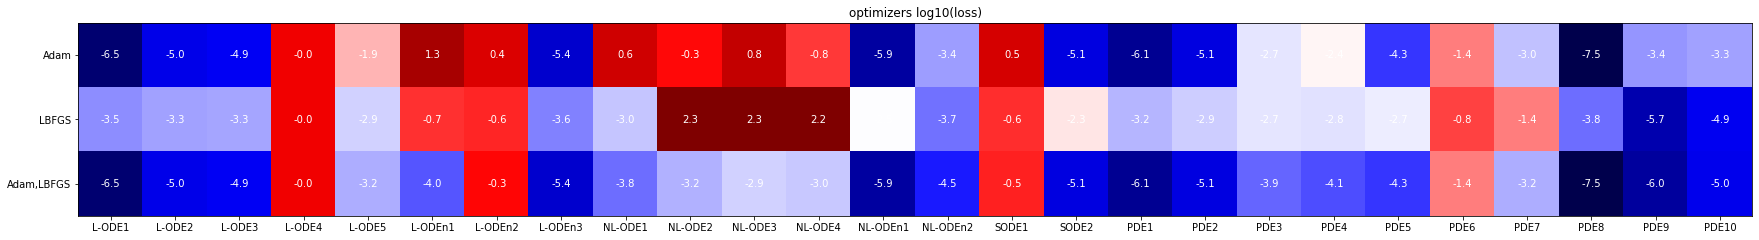

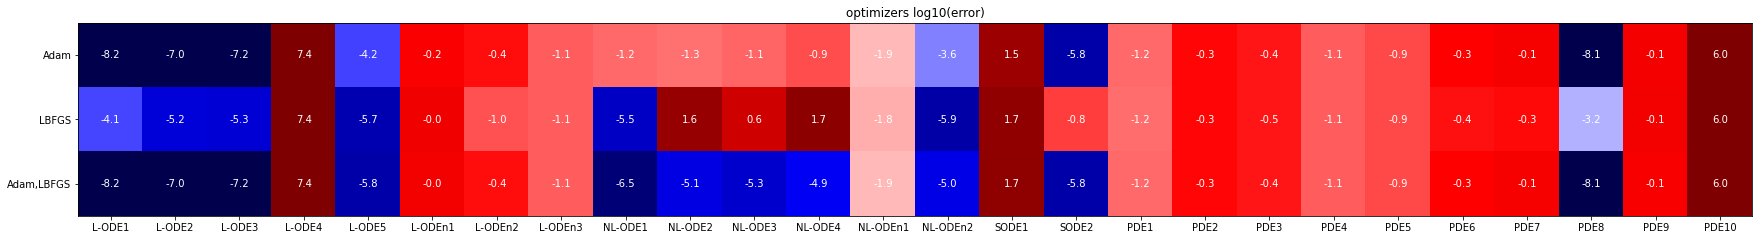

In [13]:
make_plots(
    db="db2",
    params=[[1,0],[0,1],[1,1]],
    param_name="optimizers",
    row_labels=["Adam", "LBFGS", "Adam,LBFGS"]
)

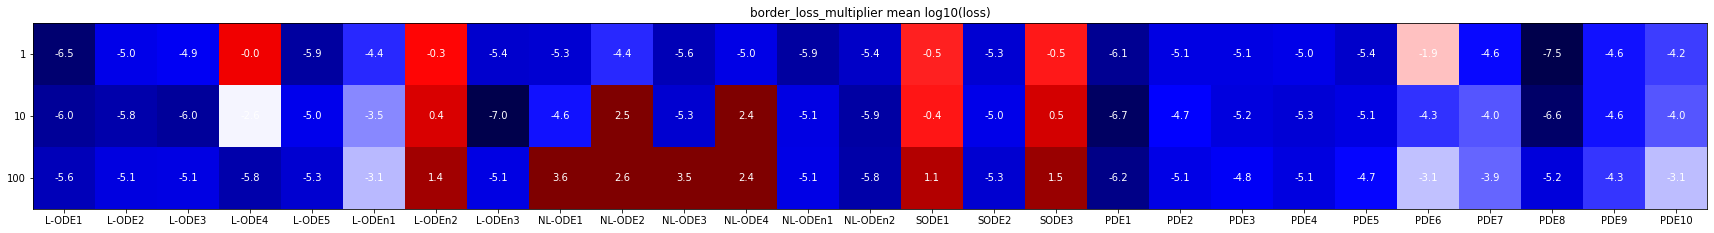

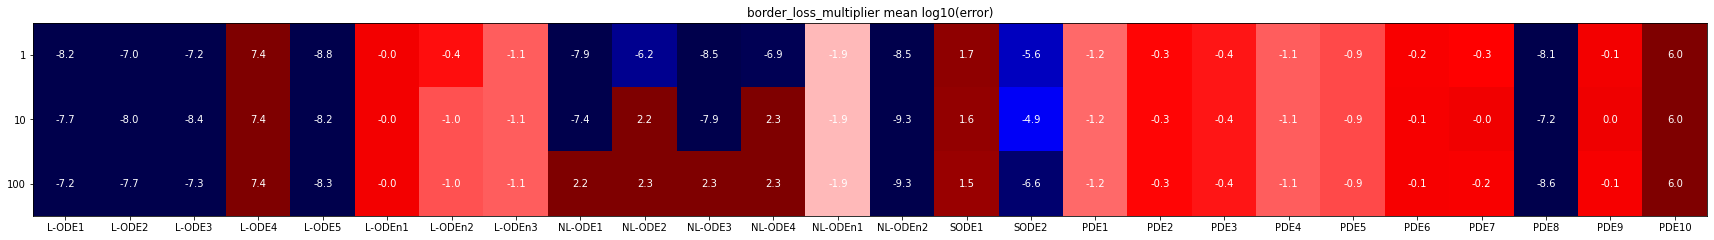

ode       1                     10                    100
--------  --------------------  --------------------  --------------------
L-ODE1    -6.52e+00, -8.16e+00  -6.02e+00, -7.70e+00  -5.59e+00, -7.19e+00
L-ODE2    -5.01e+00, -6.98e+00  -5.79e+00, -8.01e+00  -5.10e+00, -7.75e+00
L-ODE3    -4.87e+00, -7.22e+00  -5.99e+00, -8.37e+00  -5.10e+00, -7.35e+00
L-ODE4    -2.40e-02, 7.37e+00   -2.60e+00, 7.37e+00   -5.79e+00, 7.37e+00
L-ODE5    -5.92e+00, -8.79e+00  -4.98e+00, -8.21e+00  -5.31e+00, -8.26e+00
L-ODEn1   -4.38e+00, -4.51e-02  -3.52e+00, -4.51e-02  -3.10e+00, -4.51e-02
L-ODEn2   -3.02e-01, -3.64e-01  3.98e-01, -9.65e-01   1.39e+00, -9.61e-01
L-ODEn3   -5.35e+00, -1.08e+00  -6.98e+00, -1.08e+00  -5.09e+00, -1.08e+00
NL-ODE1   -5.29e+00, -7.93e+00  -4.60e+00, -7.37e+00  3.56e+00, 2.23e+00
NL-ODE2   -4.37e+00, -6.15e+00  2.52e+00, 2.24e+00    2.55e+00, 2.33e+00
NL-ODE3   -5.64e+00, -8.53e+00  -5.31e+00, -7.89e+00  3.55e+00, 2.25e+00
NL-ODE4   -5.05e+00, -6.88e+00  2.41e+00, 2.28e+00

<ipython-input-21-46f30b7fcc7c>:44: RuntimeWarning: invalid value encountered in log10
  np.log10(np.mean([x["errors"][-1] for x in res[ode][str(param)]]))


In [23]:
make_plots(
    db="db3",
    params=[1, 10, 100],
    param_name="border_loss_multiplier"
)

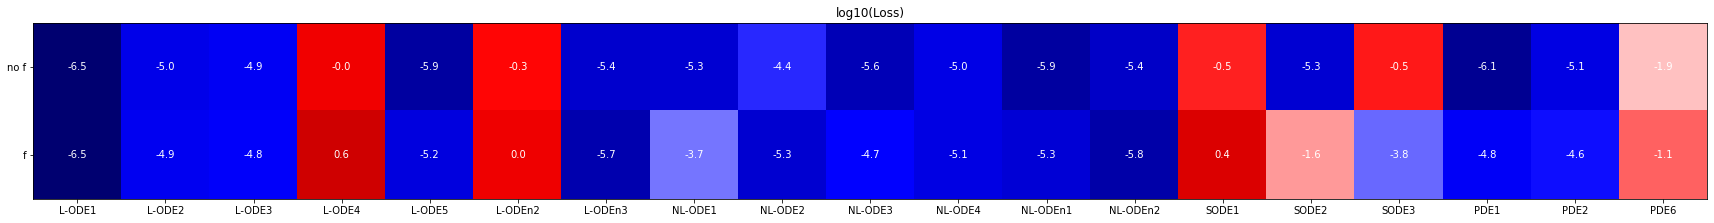

In [30]:
experiments1 = [x["payload"] for x in query("db3") if x["payload"]["kwargs"]["border_loss_multiplier"] == 1]
experiments4 = [x["payload"] for x in query("db4")]
odes = ["L-ODE1", "L-ODE2", "L-ODE3", "L-ODE4", "L-ODE5", "L-ODEn2", "L-ODEn3", "NL-ODE1", "NL-ODE2", "NL-ODE3", "NL-ODE4", "NL-ODEn1", "NL-ODEn2", "SODE1", "SODE2", "SODE3", "PDE1", "PDE2", "PDE6"]
data = np.log10(np.array([[
        np.mean([x["losses"][-1] for x in experiments1 if x["kwargs"]["ode"] == ode]) for ode in odes
    ], [
        np.mean([x["losses"][-1] for x in experiments4 if x["kwargs"]["ode"] == ode]) for ode in odes
    ]]))
plt.figure(figsize=(30,10))
im = plt.imshow(data, vmin=-7, vmax=2, cmap="seismic")

plt.xticks(np.arange(len(odes)), odes)
plt.yticks(np.arange(2), ["no f", "f"])

for i in range(2):
    for j in range(len(odes)):
        plt.text(j, i, f"{data[i, j]:.1f}", ha="center", va="center", color="w")

plt.title("log10(Loss)")
plt.show()

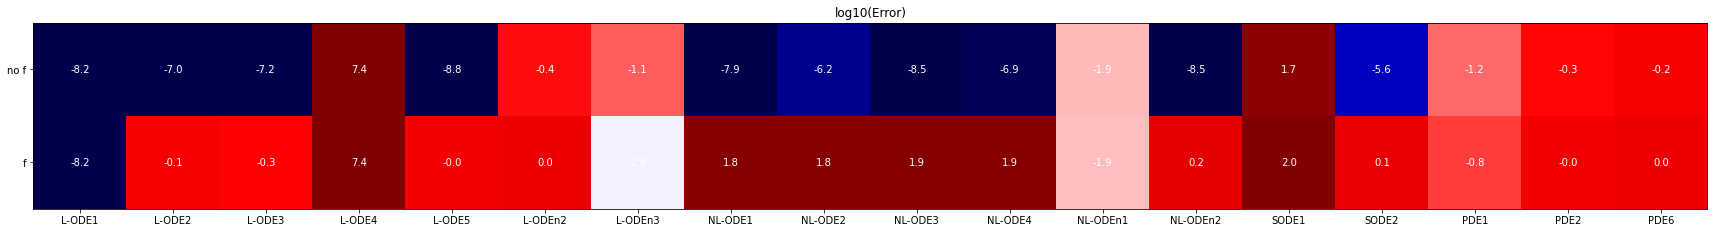

In [32]:
experiments1 = [x["payload"] for x in query("db3") if x["payload"]["kwargs"]["border_loss_multiplier"] == 1]
experiments4 = [x["payload"] for x in query("db4")]
odes = ["L-ODE1", "L-ODE2", "L-ODE3", "L-ODE4", "L-ODE5", "L-ODEn2", "L-ODEn3", "NL-ODE1", "NL-ODE2", "NL-ODE3", "NL-ODE4", "NL-ODEn1", "NL-ODEn2", "SODE1", "SODE2", "PDE1", "PDE2", "PDE6"]
data = np.log10(np.array([[
        np.mean([x["errors"][-1] for x in experiments1 if x["kwargs"]["ode"] == ode]) for ode in odes
    ], [
        np.mean([x["errors"][-1] for x in experiments4 if x["kwargs"]["ode"] == ode]) for ode in odes
    ]]))
plt.figure(figsize=(30,10))
im = plt.imshow(data, vmin=-7, vmax=2, cmap="seismic")

plt.xticks(np.arange(len(odes)), odes)
plt.yticks(np.arange(2), ["no f", "f"])

for i in range(2):
    for j in range(len(odes)):
        plt.text(j, i, f"{data[i, j]:.1f}", ha="center", va="center", color="w")

plt.title("log10(Error)")
plt.show()

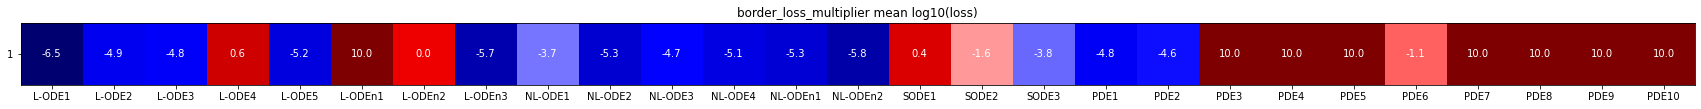

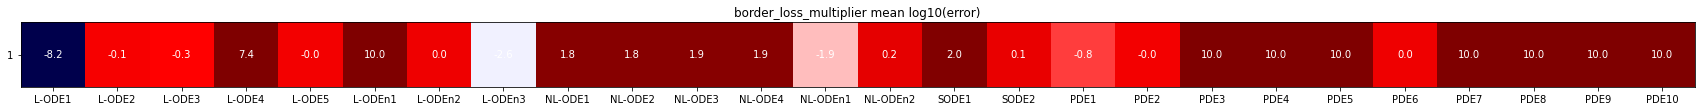

ode       1
--------  --------------------
L-ODE1    -6.52e+00, -8.16e+00
L-ODE2    -4.90e+00, -1.21e-01
L-ODE3    -4.82e+00, -2.72e-01
L-ODE4    5.78e-01, 7.37e+00
L-ODE5    -5.16e+00, -4.72e-02
L-ODEn1   nan, nan
L-ODEn2   3.54e-05, 4.27e-04
L-ODEn3   -5.75e+00, -2.61e+00
NL-ODE1   -3.72e+00, 1.83e+00
NL-ODE2   -5.33e+00, 1.83e+00
NL-ODE3   -4.75e+00, 1.85e+00
NL-ODE4   -5.08e+00, 1.85e+00
NL-ODEn1  -5.27e+00, -1.93e+00
NL-ODEn2  -5.81e+00, 1.99e-01
SODE1     3.62e-01, 1.96e+00
SODE2     -1.59e+00, 1.09e-01
SODE3     -3.81e+00, nan
PDE1      -4.83e+00, -8.06e-01
PDE2      -4.62e+00, -4.00e-02
PDE3      nan, nan
PDE4      nan, nan
PDE5      nan, nan
PDE6      -1.11e+00, 2.60e-02
PDE7      nan, nan
PDE8      nan, nan
PDE9      nan, nan
PDE10     nan, nan


<ipython-input-21-46f30b7fcc7c>:44: RuntimeWarning: invalid value encountered in log10
  np.log10(np.mean([x["errors"][-1] for x in res[ode][str(param)]]))


In [24]:
make_plots(
    db="db4",
    params=[1],
    param_name="border_loss_multiplier"
)

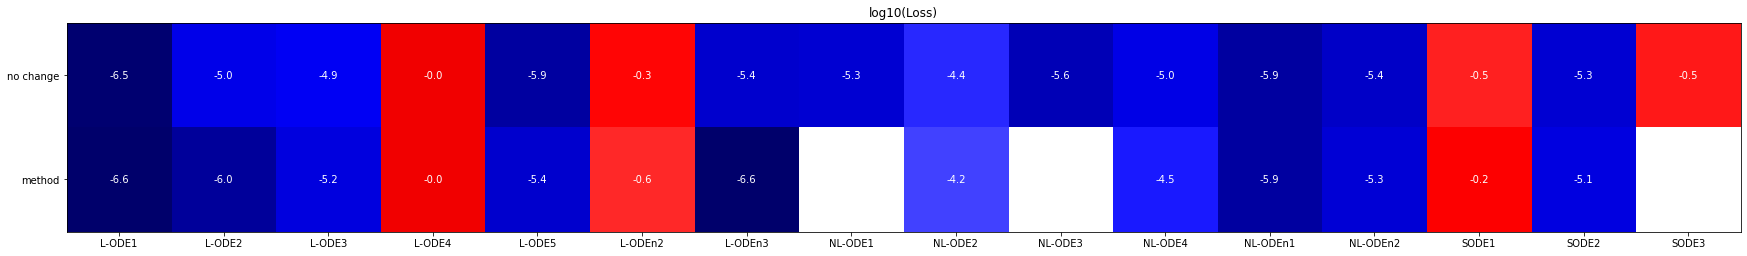

In [37]:
experiments1 = [x["payload"] for x in query("db3") if x["payload"]["kwargs"]["border_loss_multiplier"] == 1]
experiments4 = [x["payload"] for x in query("db5")]
odes = ["L-ODE1", "L-ODE2", "L-ODE3", "L-ODE4", "L-ODE5", "L-ODEn2", "L-ODEn3", "NL-ODE1", "NL-ODE2", "NL-ODE3", "NL-ODE4", "NL-ODEn1", "NL-ODEn2", "SODE1", "SODE2", "SODE3"]
data = np.log10(np.array([[
        np.mean([x["losses"][-1] for x in experiments1 if x["kwargs"]["ode"] == ode]) for ode in odes
    ], [
        np.mean([x["losses"][-1] for x in experiments4 if x["kwargs"]["ode"] == ode]) for ode in odes
    ]]))
plt.figure(figsize=(30,10))
im = plt.imshow(data, vmin=-7, vmax=2, cmap="seismic")

plt.xticks(np.arange(len(odes)), odes)
plt.yticks(np.arange(2), ["no change", "method"])

for i in range(2):
    for j in range(len(odes)):
        plt.text(j, i, f"{data[i, j]:.1f}", ha="center", va="center", color="w")

plt.title("log10(Loss)")
plt.show()

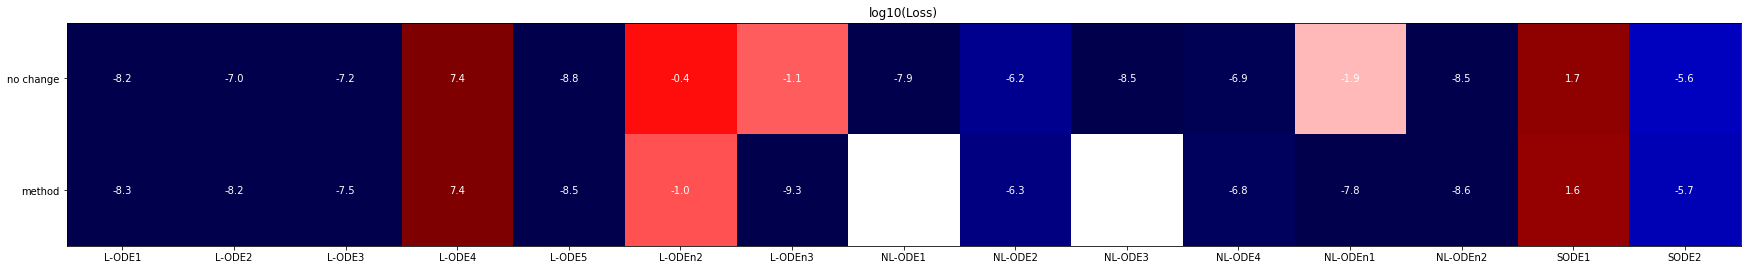

In [38]:
experiments1 = [x["payload"] for x in query("db3") if x["payload"]["kwargs"]["border_loss_multiplier"] == 1]
experiments4 = [x["payload"] for x in query("db5")]
odes = ["L-ODE1", "L-ODE2", "L-ODE3", "L-ODE4", "L-ODE5", "L-ODEn2", "L-ODEn3", "NL-ODE1", "NL-ODE2", "NL-ODE3", "NL-ODE4", "NL-ODEn1", "NL-ODEn2", "SODE1", "SODE2"]
data = np.log10(np.array([[
        np.mean([x["errors"][-1] for x in experiments1 if x["kwargs"]["ode"] == ode]) for ode in odes
    ], [
        np.mean([x["errors"][-1] for x in experiments4 if x["kwargs"]["ode"] == ode]) for ode in odes
    ]]))
plt.figure(figsize=(30,10))
im = plt.imshow(data, vmin=-7, vmax=2, cmap="seismic")

plt.xticks(np.arange(len(odes)), odes)
plt.yticks(np.arange(2), ["no change", "method"])

for i in range(2):
    for j in range(len(odes)):
        plt.text(j, i, f"{data[i, j]:.1f}", ha="center", va="center", color="w")

plt.title("log10(Loss)")
plt.show()

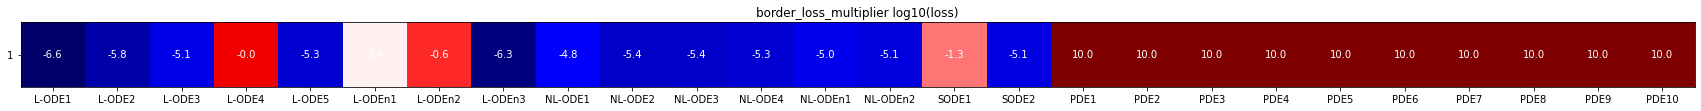

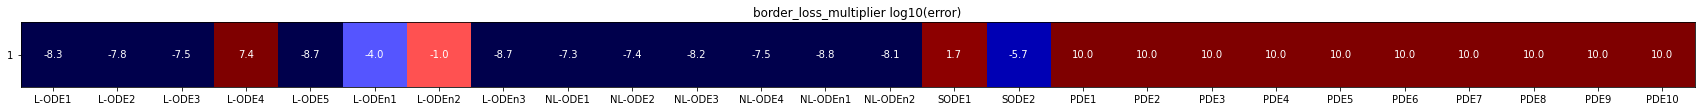

In [39]:
make_plots(
    db="db6",
    params=[1],
    param_name="border_loss_multiplier"
)

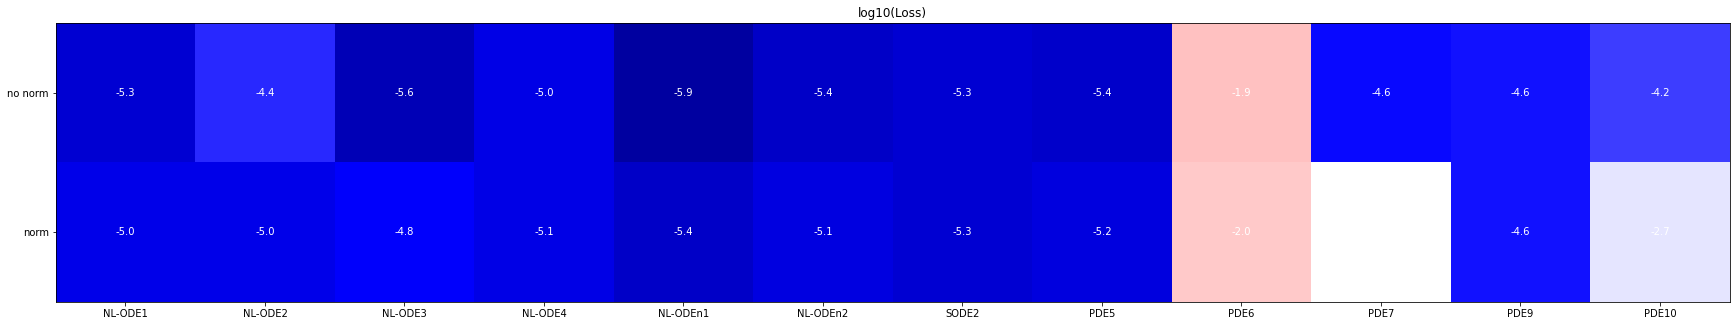

In [44]:
experiments1 = [x["payload"] for x in query("db3") if x["payload"]["kwargs"]["border_loss_multiplier"] == 1]
experiments4 = [x["payload"] for x in query("db7")]
odes = ["NL-ODE1", "NL-ODE2", "NL-ODE3", "NL-ODE4", "NL-ODEn1", "NL-ODEn2", "SODE2", "PDE5", "PDE6", "PDE7", "PDE9", "PDE10"]
data = np.log10(np.array([[
        np.mean([x["losses"][-1] for x in experiments1 if x["kwargs"]["ode"] == ode]) for ode in odes
    ], [
        np.mean([x["losses"][-1] for x in experiments4 if x["kwargs"]["ode"] == ode]) for ode in odes
    ]]))
plt.figure(figsize=(30,10))
im = plt.imshow(data, vmin=-7, vmax=2, cmap="seismic")

plt.xticks(np.arange(len(odes)), odes)
plt.yticks(np.arange(2), ["no norm", "norm"])

for i in range(2):
    for j in range(len(odes)):
        plt.text(j, i, f"{data[i, j]:.1f}", ha="center", va="center", color="w")

plt.title("log10(Loss)")
plt.show()

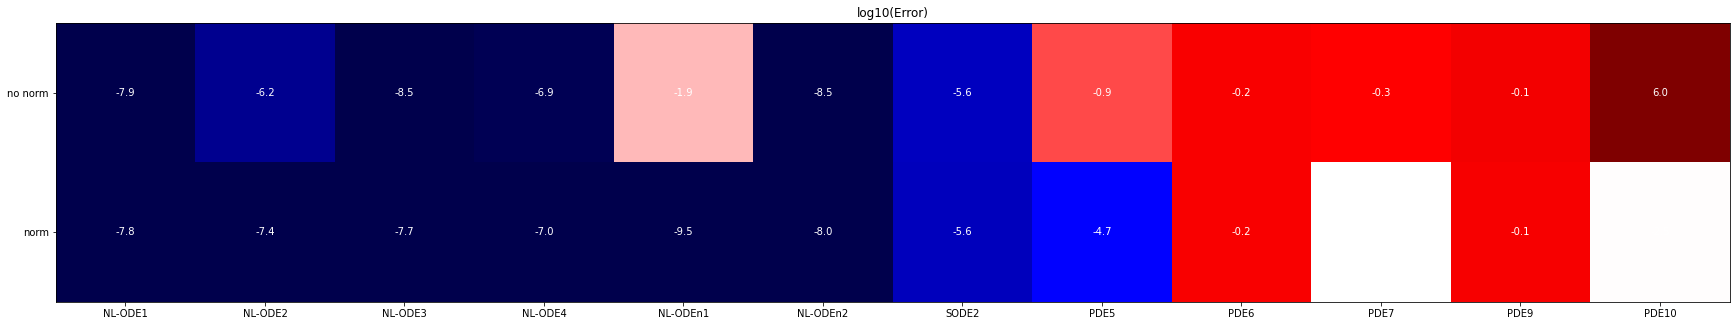

In [43]:
experiments1 = [x["payload"] for x in query("db3") if x["payload"]["kwargs"]["border_loss_multiplier"] == 1]
experiments4 = [x["payload"] for x in query("db7")]
odes = ["NL-ODE1", "NL-ODE2", "NL-ODE3", "NL-ODE4", "NL-ODEn1", "NL-ODEn2", "SODE2", "PDE5", "PDE6", "PDE7", "PDE9", "PDE10"]
data = np.log10(np.array([[
        np.mean([x["errors"][-1] for x in experiments1 if x["kwargs"]["ode"] == ode]) for ode in odes
    ], [
        np.mean([x["errors"][-1] for x in experiments4 if x["kwargs"]["ode"] == ode]) for ode in odes
    ]]))
plt.figure(figsize=(30,10))
im = plt.imshow(data, vmin=-7, vmax=2, cmap="seismic")

plt.xticks(np.arange(len(odes)), odes)
plt.yticks(np.arange(2), ["no norm", "norm"])

for i in range(2):
    for j in range(len(odes)):
        plt.text(j, i, f"{data[i, j]:.1f}", ha="center", va="center", color="w")

plt.title("log10(Error)")
plt.show()

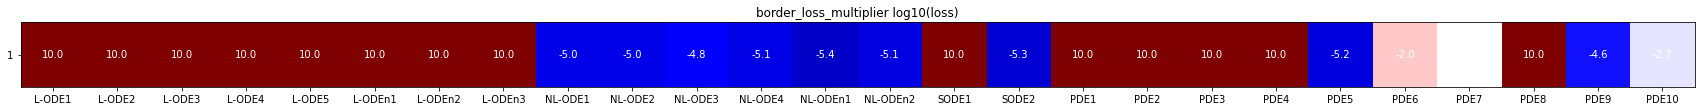

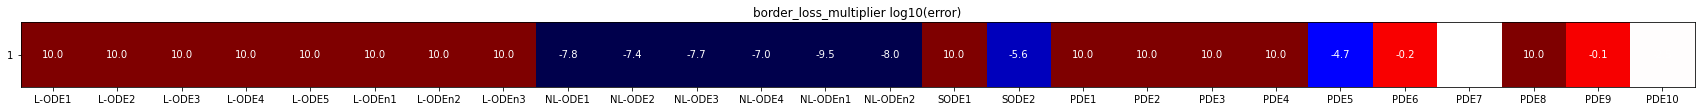

In [40]:
make_plots(
    db="db7",
    params=[1],
    param_name="border_loss_multiplier"
)

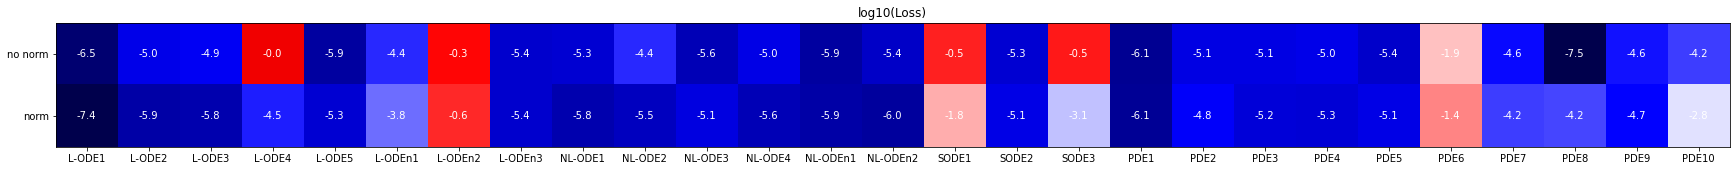

In [46]:
experiments1 = [x["payload"] for x in query("db3") if x["payload"]["kwargs"]["border_loss_multiplier"] == 1]
experiments4 = [x["payload"] for x in query("db8")]
odes = ODES
data = np.log10(np.array([[
        np.mean([x["losses"][-1] for x in experiments1 if x["kwargs"]["ode"] == ode]) for ode in odes
    ], [
        np.mean([x["losses"][-1] for x in experiments4 if x["kwargs"]["ode"] == ode]) for ode in odes
    ]]))
plt.figure(figsize=(30,10))
im = plt.imshow(data, vmin=-7, vmax=2, cmap="seismic")

plt.xticks(np.arange(len(odes)), odes)
plt.yticks(np.arange(2), ["no norm", "norm"])

for i in range(2):
    for j in range(len(odes)):
        plt.text(j, i, f"{data[i, j]:.1f}", ha="center", va="center", color="w")

plt.title("log10(Loss)")
plt.show()

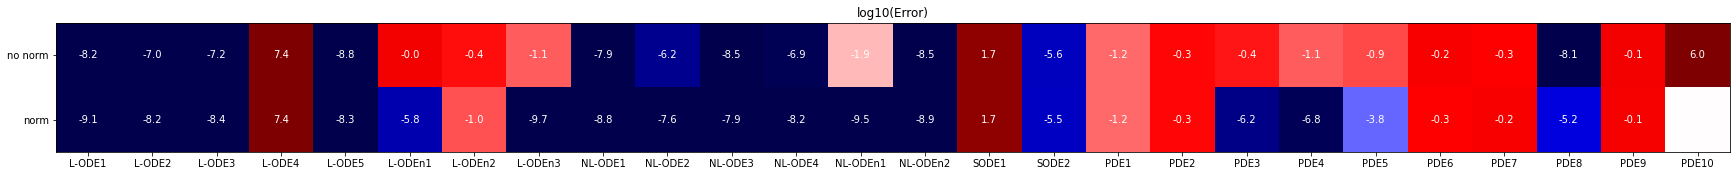

In [45]:
experiments1 = [x["payload"] for x in query("db3") if x["payload"]["kwargs"]["border_loss_multiplier"] == 1]
experiments4 = [x["payload"] for x in query("db8")]
odes = ODES_
data = np.log10(np.array([[
        np.mean([x["errors"][-1] for x in experiments1 if x["kwargs"]["ode"] == ode]) for ode in odes
    ], [
        np.mean([x["errors"][-1] for x in experiments4 if x["kwargs"]["ode"] == ode]) for ode in odes
    ]]))
plt.figure(figsize=(30,10))
im = plt.imshow(data, vmin=-7, vmax=2, cmap="seismic")

plt.xticks(np.arange(len(odes)), odes)
plt.yticks(np.arange(2), ["no norm", "norm"])

for i in range(2):
    for j in range(len(odes)):
        plt.text(j, i, f"{data[i, j]:.1f}", ha="center", va="center", color="w")

plt.title("log10(Error)")
plt.show()

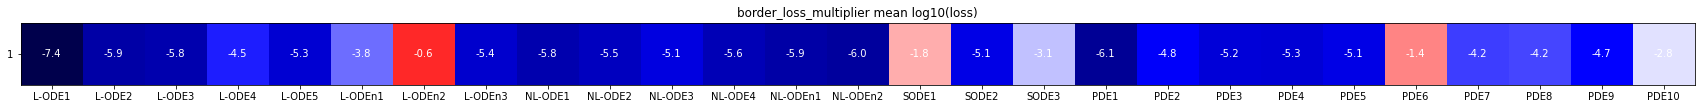

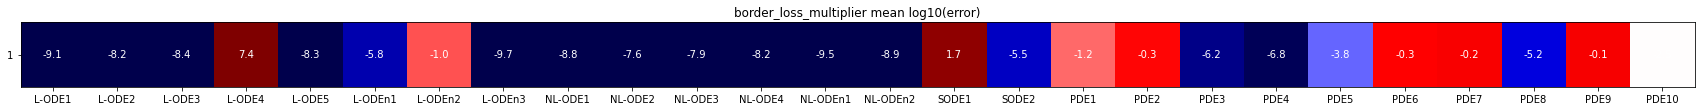

ode       1
--------  --------------------
L-ODE1    -7.45e+00, -9.14e+00
L-ODE2    -5.87e+00, -8.19e+00
L-ODE3    -5.76e+00, -8.42e+00
L-ODE4    -4.47e+00, 7.37e+00
L-ODE5    -5.30e+00, -8.35e+00
L-ODEn1   -3.80e+00, -5.75e+00
L-ODEn2   -6.02e-01, -9.65e-01
L-ODEn3   -5.36e+00, -9.74e+00
NL-ODE1   -5.76e+00, -8.85e+00
NL-ODE2   -5.53e+00, -7.61e+00
NL-ODE3   -5.12e+00, -7.94e+00
NL-ODE4   -5.63e+00, -8.17e+00
NL-ODEn1  -5.87e+00, -9.53e+00
NL-ODEn2  -5.95e+00, -8.88e+00
SODE1     -1.77e+00, 1.71e+00
SODE2     -5.06e+00, -5.50e+00
SODE3     -3.06e+00, nan
PDE1      -6.06e+00, -1.19e+00
PDE2      -4.80e+00, -3.08e-01
PDE3      -5.22e+00, -6.24e+00
PDE4      -5.26e+00, -6.83e+00
PDE5      -5.06e+00, -3.84e+00
PDE6      -1.42e+00, -2.63e-01
PDE7      -4.22e+00, -1.57e-01
PDE8      -4.15e+00, -5.17e+00
PDE9      -4.72e+00, -1.31e-01
PDE10     -2.78e+00, -2.49e+00


<ipython-input-21-46f30b7fcc7c>:44: RuntimeWarning: invalid value encountered in log10
  np.log10(np.mean([x["errors"][-1] for x in res[ode][str(param)]]))


In [26]:
make_plots(
    db="db8",
    params=[1],
    param_name="border_loss_multiplier"
)

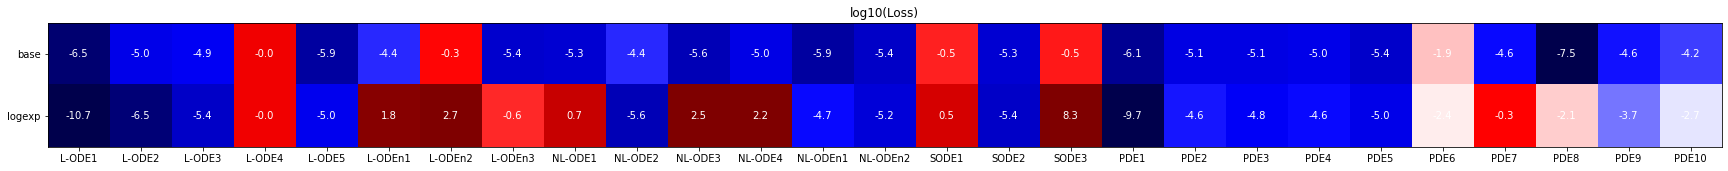

In [47]:
experiments1 = [x["payload"] for x in query("db3") if x["payload"]["kwargs"]["border_loss_multiplier"] == 1]
experiments4 = [x["payload"] for x in query("db9")]
odes = ODES
data = np.log10(np.array([[
        np.mean([x["losses"][-1] for x in experiments1 if x["kwargs"]["ode"] == ode]) for ode in odes
    ], [
        np.mean([x["losses"][-1] for x in experiments4 if x["kwargs"]["ode"] == ode]) for ode in odes
    ]]))
plt.figure(figsize=(30,10))
im = plt.imshow(data, vmin=-7, vmax=2, cmap="seismic")

plt.xticks(np.arange(len(odes)), odes)
plt.yticks(np.arange(2), ["base", "logexp"])

for i in range(2):
    for j in range(len(odes)):
        plt.text(j, i, f"{data[i, j]:.1f}", ha="center", va="center", color="w")

plt.title("log10(Loss)")
plt.show()

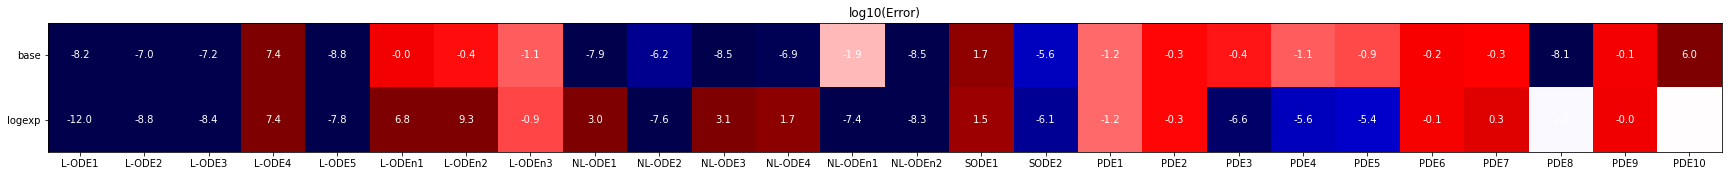

In [48]:
experiments1 = [x["payload"] for x in query("db3") if x["payload"]["kwargs"]["border_loss_multiplier"] == 1]
experiments4 = [x["payload"] for x in query("db9")]
odes = ODES_
data = np.log10(np.array([[
        np.mean([x["errors"][-1] for x in experiments1 if x["kwargs"]["ode"] == ode]) for ode in odes
    ], [
        np.mean([x["errors"][-1] for x in experiments4 if x["kwargs"]["ode"] == ode]) for ode in odes
    ]]))
plt.figure(figsize=(30,10))
im = plt.imshow(data, vmin=-7, vmax=2, cmap="seismic")

plt.xticks(np.arange(len(odes)), odes)
plt.yticks(np.arange(2), ["base", "logexp"])

for i in range(2):
    for j in range(len(odes)):
        plt.text(j, i, f"{data[i, j]:.1f}", ha="center", va="center", color="w")

plt.title("log10(Error)")
plt.show()

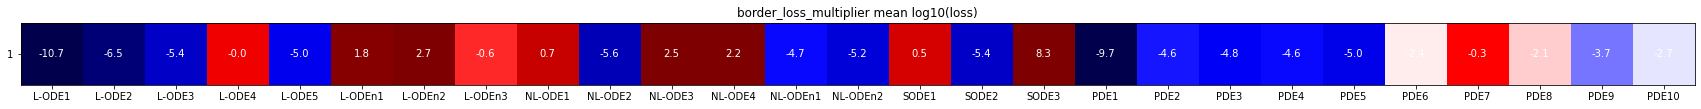

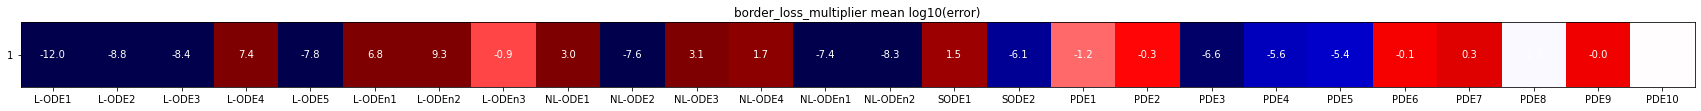

ode       1
--------  --------------------
L-ODE1    -1.07e+01, -1.20e+01
L-ODE2    -6.47e+00, -8.83e+00
L-ODE3    -5.44e+00, -8.41e+00
L-ODE4    -2.02e-02, 7.37e+00
L-ODE5    -4.95e+00, -7.76e+00
L-ODEn1   1.84e+00, 6.84e+00
L-ODEn2   2.65e+00, 9.32e+00
L-ODEn3   -6.13e-01, -8.64e-01
NL-ODE1   7.34e-01, 2.96e+00
NL-ODE2   -5.64e+00, -7.65e+00
NL-ODE3   2.53e+00, 3.08e+00
NL-ODE4   2.21e+00, 1.75e+00
NL-ODEn1  -4.66e+00, -7.37e+00
NL-ODEn2  -5.22e+00, -8.29e+00
SODE1     4.83e-01, 1.46e+00
SODE2     -5.44e+00, -6.07e+00
SODE3     8.28e+00, nan
PDE1      -9.73e+00, -1.20e+00
PDE2      -4.56e+00, -3.09e-01
PDE3      -4.84e+00, -6.64e+00
PDE4      -4.64e+00, -5.58e+00
PDE5      -5.03e+00, -5.40e+00
PDE6      -2.35e+00, -1.39e-01
PDE7      -2.82e-01, 2.86e-01
PDE8      -2.07e+00, -2.55e+00
PDE9      -3.71e+00, -2.96e-02
PDE10     -2.72e+00, -2.48e+00


<ipython-input-21-46f30b7fcc7c>:44: RuntimeWarning: invalid value encountered in log10
  np.log10(np.mean([x["errors"][-1] for x in res[ode][str(param)]]))


In [27]:
make_plots(
    db="db9",
    params=[1],
    param_name="border_loss_multiplier"
)

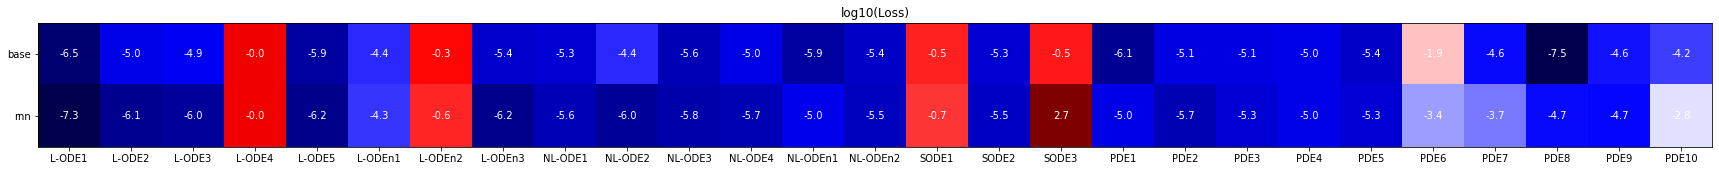

In [50]:
experiments1 = [x["payload"] for x in query("db3") if x["payload"]["kwargs"]["border_loss_multiplier"] == 1]
experiments4 = [x["payload"] for x in query("db")]
odes = ODES
data = np.log10(np.array([[
        np.mean([x["losses"][-1] for x in experiments1 if x["kwargs"]["ode"] == ode]) for ode in odes
    ], [
        np.mean([x["losses"][-1] for x in experiments4 if x["kwargs"]["ode"] == ode]) for ode in odes
    ]]))
plt.figure(figsize=(30,10))
im = plt.imshow(data, vmin=-7, vmax=2, cmap="seismic")

plt.xticks(np.arange(len(odes)), odes)
plt.yticks(np.arange(2), ["base", "rnn"])

for i in range(2):
    for j in range(len(odes)):
        plt.text(j, i, f"{data[i, j]:.1f}", ha="center", va="center", color="w")

plt.title("log10(Loss)")
plt.show()

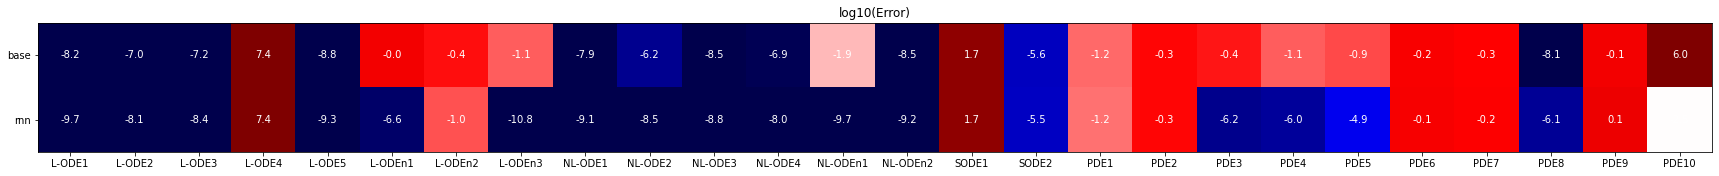

In [49]:
experiments1 = [x["payload"] for x in query("db3") if x["payload"]["kwargs"]["border_loss_multiplier"] == 1]
experiments4 = [x["payload"] for x in query("db")]
odes = ODES_
data = np.log10(np.array([[
        np.mean([x["errors"][-1] for x in experiments1 if x["kwargs"]["ode"] == ode]) for ode in odes
    ], [
        np.mean([x["errors"][-1] for x in experiments4 if x["kwargs"]["ode"] == ode]) for ode in odes
    ]]))
plt.figure(figsize=(30,10))
im = plt.imshow(data, vmin=-7, vmax=2, cmap="seismic")

plt.xticks(np.arange(len(odes)), odes)
plt.yticks(np.arange(2), ["base", "rnn"])

for i in range(2):
    for j in range(len(odes)):
        plt.text(j, i, f"{data[i, j]:.1f}", ha="center", va="center", color="w")

plt.title("log10(Error)")
plt.show()

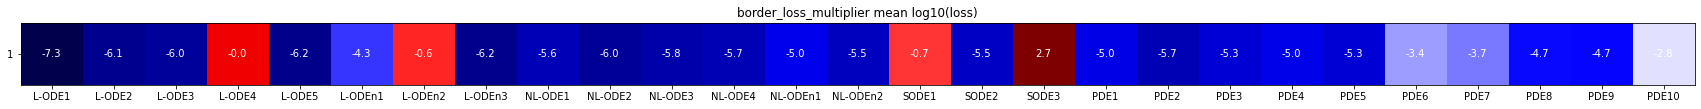

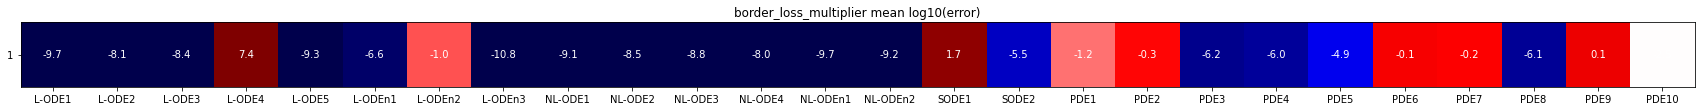

ode       1
--------  --------------------
L-ODE1    -7.31e+00, -9.73e+00
L-ODE2    -6.12e+00, -8.11e+00
L-ODE3    -6.00e+00, -8.39e+00
L-ODE4    -2.25e-02, 7.37e+00
L-ODE5    -6.22e+00, -9.35e+00
L-ODEn1   -4.28e+00, -6.62e+00
L-ODEn2   -6.01e-01, -9.62e-01
L-ODEn3   -6.18e+00, -1.08e+01
NL-ODE1   -5.64e+00, -9.15e+00
NL-ODE2   -6.04e+00, -8.47e+00
NL-ODE3   -5.77e+00, -8.82e+00
NL-ODE4   -5.67e+00, -7.96e+00
NL-ODEn1  -4.97e+00, -9.72e+00
NL-ODEn2  -5.55e+00, -9.17e+00
SODE1     -7.15e-01, 1.72e+00
SODE2     -5.46e+00, -5.51e+00
SODE3     2.71e+00, nan
PDE1      -5.04e+00, -1.24e+00
PDE2      -5.69e+00, -3.10e-01
PDE3      -5.25e+00, -6.19e+00
PDE4      -5.02e+00, -6.01e+00
PDE5      -5.27e+00, -4.93e+00
PDE6      -3.37e+00, -1.29e-01
PDE7      -3.69e+00, -2.48e-01
PDE8      -4.66e+00, -6.06e+00
PDE9      -4.68e+00, 6.02e-02
PDE10     -2.76e+00, -2.49e+00


<ipython-input-21-46f30b7fcc7c>:44: RuntimeWarning: invalid value encountered in log10
  np.log10(np.mean([x["errors"][-1] for x in res[ode][str(param)]]))


In [48]:
make_plots(
    db="db",
    params=[1],
    param_name="border_loss_multiplier"
)

In [47]:
for i, x in enumerate(query("db")):
    p = x["payload"]["kwargs"]
    ode = p["ode"]
    print(f"{i}: {ode}")

0: L-ODE1
1: L-ODE2
2: L-ODE3
3: L-ODE4
4: L-ODE5
5: L-ODEn1
6: L-ODEn2
7: L-ODEn3
8: NL-ODE1
9: NL-ODE2
10: NL-ODE3
11: NL-ODE4
12: NL-ODEn1
13: NL-ODEn2
14: SODE1
15: SODE2
16: SODE3
17: PDE1
18: PDE2
19: PDE3
20: PDE4
21: PDE5
22: PDE6
23: PDE7
24: PDE8
25: PDE9
26: PDE10
